### Multi-layer Perceptron Scratch Work

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read all of the words
words = open("names.txt").read().splitlines()
print(f'Length: {len(words)} | Sample: {words[:4]}')

Length: 32033 | Sample: ['emma', 'olivia', 'ava', 'isabella']


In [63]:
# Build the vocabulary set
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [4]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
# build the datasets
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
# build the lookup table
C = torch.rand((27, 2))

In [8]:
# C[5] == F.one_hot(torch.tensor(5), num_classes=27).float() @ C
# Tells us that we can think of first layer of nueral net 
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [9]:
W1 = torch.randn((6, 100))
b1 = torch.rand((100))

In [10]:
# emb @ W1 + b1 || Doesn't work, because we need to convert 32, 3, 2 into 32, 6
# How can we do this? Many ways, but we want to concatonate emb
# ??? torch.cat((emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]), dim=1).shape | NO
# ??? torch.cat([emb[:, i, :] for i in range(emb.shape[1])], dim=1) | NO
# torch.cat(torch.unbind(emb, dim=1), dim=1).shape # | NO
# Concat create all kinds of new memory and is inefficient
# emb.view(32, 6).shape # | YES!
# -1 in view infers the shape
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
# always good practice to double check broadcasting

In [11]:
h.shape

torch.Size([228146, 100])

In [12]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
logits = h @ W2 + b2

In [13]:
counts = logits.exp()

In [14]:
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([228146, 27])

In [15]:
# Index into rows of prob and pluck 
# nll= -prob[torch.arange(32), Y].log().mean()
# nll # loss we would like to minimize

In [16]:
# ---------------------- Buttoned Up ---------------------- #

In [17]:
# Dataset
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [47]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [39]:
print(f'Total Parameters: {sum(p.nelement() for p in parameters)}')

Total Parameters: 11897


In [48]:
for p in parameters:
    p.requires_grad = True

In [49]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [50]:
lri = []
lossi = []
stepi = []

In [58]:
for i in range(50000):
    # constuct mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # Since we are using mini-batches, we have an approximate gradient, not the actual gradient

    # Forward Pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30)@W1 +b1) # (32, 100)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) # Use this instead of from scratch, for efficiency
    # print(loss.item())
    # Backward Pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    # update
    for p in parameters:
        # How do you determine lr
        lr = 0.01
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

# print(f"Minibatch Loss: {loss}")

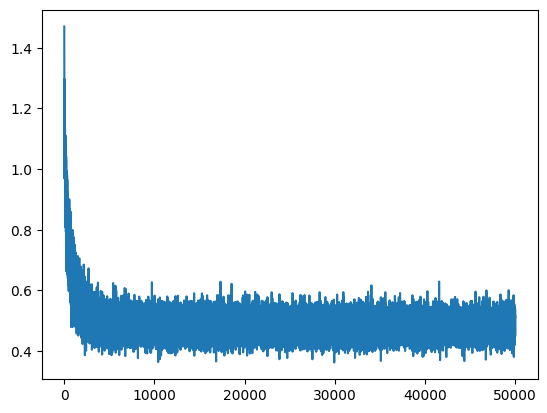

In [52]:
plt.plot(stepi, lossi)

In [59]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.8316, grad_fn=<NllLossBackward0>)

In [60]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.8297, grad_fn=<NllLossBackward0>)

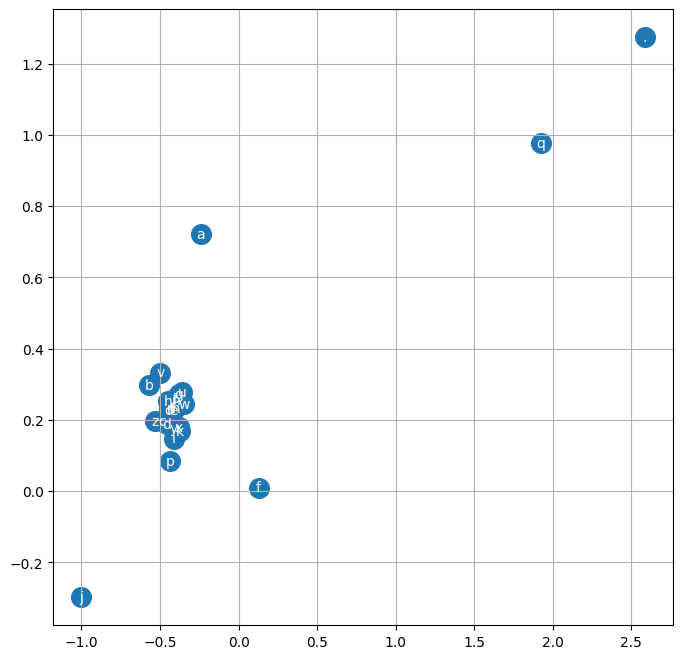

In [61]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [27]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [62]:
# sample from the mdoel
g = torch.Generator().manual_seed(2146483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0: break
    
    print(''.join(itos[i] for i in out))

nahscartarynicoaiktssadakia.
rahwi.
aeeana.
lh.
lnaomatiaylaia.
ajee.
aa.
d.
j.
vmc.
mng.
ashetz.
llsannnynieah.
fyi.
nreiieapnahnzrocras.
.
.
fyri.
ae.
c.
